Import Dependencies

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import SimpleRNN, Activation, Dense, Flatten, Dropout, LSTM, TextVectorization, Embedding, Bidirectional
from keras.utils import Sequence
import numpy as np
import tensorflow as tf
import random
import pandas as pd
import csv
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import sys


all_inputs_raw = ["da_dataset.txt",
                  "de_dataset.txt",
                  "en_dataset.txt",
                  "eo_dataset.txt",
                  "es_dataset.txt",
                  "fr_dataset.txt",
                  "it_dataset.txt",
                  "la_dataset.txt",
                  "ru_dataset.txt",
                  "sv_dataset.txt"
                  ]
all_input_files = ["da_dataset_shuffled_full_cleaned.txt",
                   "de_dataset_shuffled_full_cleaned.txt",
                   "en_dataset_shuffled_full_cleaned.txt",
                   "eo_dataset_shuffled_full_cleaned.txt",
                   "es_dataset_shuffled_full_cleaned.txt",
                   "fr_dataset_shuffled_full_cleaned.txt",
                   "it_dataset_shuffled_full_cleaned.txt",
                   "la_dataset_shuffled_full_cleaned.txt",
                   "ru_dataset_shuffled_full_cleaned.txt",
                   "sv_dataset_shuffled_full_cleaned.txt",]

Dataset Formatting: Convert .dic to .txt (Not Mandatory)

In [ ]:
def dic_to_txt_50(dic_file_path, txt_file_path):
    try:
        # Open the .dic file in read mode with ISO-8859-1 encoding
        with open(dic_file_path, 'r') as dic_file:
            # Initialize an empty list to hold the first 50 lines that match the encoding
            valid_lines = []

            # Read lines from the file, checking for encoding compatibility
            for _ in range(50):
                line = dic_file.readline()
                # Check if we have reached the end of the file
                if not line:
                    break

                try:
                    # Attempt to encode the line in ISO-8859-1
                    line.encode('ISO-8859-1')
                    # If successful, convert it to lowercase and add to the list
                    valid_lines.append(line.lower())
                except UnicodeEncodeError:
                    # If a UnicodeEncodeError occurs, skip the line as it contains characters
                    # that do not conform to ISO-8859-1 encoding
                    continue

            # Open the .txt file in write mode with UTF-8 encoding
            with open(txt_file_path, 'w', encoding='utf-8') as txt_file:
                # Write the valid lines to the .txt file
                txt_file.writelines(valid_lines)

        print("Conversion successful! The first 50 valid lines have been saved to:", txt_file_path)
    except Exception as e:
        print("An error occurred:", str(e))

dic_to_txt_50('sa-Latn.dic', 'hi_wordlist.txt')

Conversion successful! The first 50 valid lines have been saved to: hi_wordlist.txt


In [ ]:
def dic_to_txt_all(dic_file_path, txt_file_path):
    try:
        # Open the .dic file in read mode with ISO-8859-1 encoding
        with open(dic_file_path, 'r', encoding='ISO-8859-1') as dic_file:
            # Initialize an empty list to hold lines that match the encoding
            valid_lines = []

            # Read lines from the file, checking for encoding compatibility
            while True:
                line = dic_file.readline()
                # Check if we have reached the end of the file
                if not line:
                    break

                try:
                    # Attempt to encode the line in ISO-8859-1
                    line.encode('ISO-8859-1')
                    # If successful, convert it to lowercase and add to the list
                    valid_lines.append(line.lower())
                except UnicodeEncodeError:
                    # If a UnicodeEncodeError occurs, skip the line as it contains characters
                    # that do not conform to ISO-8859-1 encoding
                    continue

            # Open the .txt file in write mode with UTF-8 encoding
            with open(txt_file_path, 'w', encoding='utf-8') as txt_file:
                # Write the valid lines to the .txt file
                txt_file.writelines(valid_lines)

        print("Conversion successful! All valid lines have been saved to:", txt_file_path)
    except Exception as e:
        print("An error occurred:", str(e))

dic_to_txt_all('sa-Latn.dic', 'hi_wordlist.txt')

Conversion successful! All valid lines have been saved to: hi_wordlist.txt


Dataset Formatting: Parse JSON files to get raw txt file of words (Not Mandatory)

In [ ]:
import json

def json_list_to_text(input_json_file, output_txt_file):
    try:
        with open(input_json_file, 'r', encoding='utf-8') as infile:
            json_list = json.load(infile)

            longest_item = None  # Initialize a variable to store the longest item
            with open(output_txt_file, 'w', encoding='utf-8') as outfile:
                for item in json_list:
                    try:
                        # Convert the element to a string, remove quotation marks and commas
                        item_str = json.dumps(item, indent=4, ensure_ascii=False).replace('"', '').replace(',', '')
                        outfile.write(item_str + '\n')

                        # Check if the current item is longer than the longest item
                        if longest_item is None or len(item_str) > len(longest_item):
                            longest_item = item_str
                    except json.JSONDecodeError as e:
                        # Handle JSON decode error by skipping the problematic element
                        print(f"JSON decode error: {str(e)}. Skipping the problematic element.")

            # Print the longest item
            print(f"Longest item:\n{longest_item}")

            return f"Data written to {output_txt_file}"
    except FileNotFoundError:
        return "Input file not found"

# Example usage:
input_json_file = "index_es.json"       # Replace with the path to your JSON list file
output_txt_file = "output.txt"      # Replace with the desired output text file

result = json_list_to_text(input_json_file, output_txt_file)
print(result)

Input file not found


Normalize Text Characters (Optional)

In [ ]:

def cleanup_txt_normalize(inputFile, outputFile):
    unique_words = set()  # Create a set to keep track of unique normalized words

    with open(inputFile, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    with open(outputFile, 'w', encoding='utf-8') as f:
        for line in lines:
            words = line.split()
            for word in words:
                normalized_word = unicodedata.normalize('NFKC', word).encode('ASCII', 'ignore')
                normalized_word = normalized_word.lower()

                # Check if the normalized word is already in the set
                if normalized_word and normalized_word not in unique_words:
                    unique_words.add(normalized_word)  # Add the normalized word to the set
                    f.write(normalized_word + '\n')  # Write the word followed by a newline

cleanup_txt_normalize("hi_wordlist.txt", "hi_dataset.txt")

Shuffle Words (Required, Choose either full or non-full)

In [ ]:
def shuffle_and_extract_words_full(input_files):
    for input_file in input_files:
        # Open the input file for reading
        with open(input_file, 'r') as file:
            lines = file.readlines()

        random.shuffle(lines)

        output_file = input_file.replace('.txt', '_shuffled_full.txt')

        with open(output_file, 'w') as output:
            output.writelines(list(map(lambda x: x.lower(), lines)))

        print(f"Shuffled words (full) have been written to '{output_file}'")

shuffle_and_extract_words_full(all_inputs_raw)

Shuffled words (full) have been written to 'da_dataset_shuffled_full.txt'
Shuffled words (full) have been written to 'de_dataset_shuffled_full.txt'
Shuffled words (full) have been written to 'en_dataset_shuffled_full.txt'
Shuffled words (full) have been written to 'eo_dataset_shuffled_full.txt'
Shuffled words (full) have been written to 'es_dataset_shuffled_full.txt'
Shuffled words (full) have been written to 'fr_dataset_shuffled_full.txt'
Shuffled words (full) have been written to 'it_dataset_shuffled_full.txt'
Shuffled words (full) have been written to 'la_dataset_shuffled_full.txt'
Shuffled words (full) have been written to 'ru_dataset_shuffled_full.txt'
Shuffled words (full) have been written to 'sv_dataset_shuffled_full.txt'


In [ ]:
def shuffle_and_extract_words(input_files):
    for input_file in input_files:
        # Open the input file for reading
        with open(input_file, 'r') as file:
            lines = file.readlines()

        random.shuffle(lines)

        output_file = input_file.replace('.txt', '_shuffled_v2.txt')

        shuffled_words = lines[:200_000]

        with open(output_file, 'w') as output:
            output.writelines(list(map(lambda x: x.lower(),shuffled_words)))

        print(f"Shuffled words have been written to '{output_file}'")


shuffle_and_extract_words(all_inputs_raw)

Shuffled words have been written to 'da_dataset_shuffled_v2.txt'


KeyboardInterrupt: 

Clean up .txt (Mandatory)

In [ ]:
def cleanup_txt_files(input_files, char_limit=0):
    for inputFile in input_files:
        unique_words = set()  # Set to keep track of unique words
        longest_word = ""  # Variable to store the longest word
        longest_length = 0  # Variable to store the length of the longest word

        # Generate output file name
        outputFile = inputFile.replace('.txt', '_cleaned.txt')

        with open(inputFile, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        with open(outputFile, 'w', encoding='utf-8') as f:
            for line in lines:
                # Eliminate lines that contain spaces
                if ' ' not in line:
                    words = line.split()
                    for word in words:
                      if char_limit > 0:
                        if len(word) > char_limit:
                            continue
                      # Remove unwanted characters and convert to lowercase
                      cleaned_word = ''.join(char for char in word if char.isalpha()).lower()

                      # Update longest word if necessary
                      if len(cleaned_word) > longest_length:
                          longest_word = cleaned_word
                          longest_length = len(cleaned_word)

                      # Check if the word is already in the set
                      if cleaned_word and cleaned_word not in unique_words:
                          unique_words.add(cleaned_word)  # Add the word to the set
                          f.write(cleaned_word + '\n')  # Write the word followed by a newline

        # Print processed file, created file, and the longest word with its length
        print(f"Processed '{inputFile}', created '{outputFile}'. Longest word: '{longest_word}' Length: {longest_length}")


input_files_cleanup = ['da_dataset_shuffled_full.txt', 'de_dataset_shuffled_full.txt', 'en_dataset_shuffled_full.txt', 'eo_dataset_shuffled_full.txt', 'es_dataset_shuffled_full.txt', 'fr_dataset_shuffled_full.txt', 'it_dataset_shuffled_full.txt', 'la_dataset_shuffled_full.txt', 'ru_dataset_shuffled_full.txt', 'sv_dataset_shuffled_full.txt',]
cleanup_txt_files(input_files_cleanup, 15)


Processed 'da_dataset_shuffled_full.txt', created 'da_dataset_shuffled_full_cleaned.txt'. Longest word: 'designlisternes' Length: 15
Processed 'de_dataset_shuffled_full.txt', created 'de_dataset_shuffled_full_cleaned.txt'. Longest word: 'nebelkammerbild' Length: 15
Processed 'en_dataset_shuffled_full.txt', created 'en_dataset_shuffled_full_cleaned.txt'. Longest word: 'nondepreciative' Length: 15
Processed 'eo_dataset_shuffled_full.txt', created 'eo_dataset_shuffled_full_cleaned.txt'. Longest word: 'definitiviĝadon' Length: 15
Processed 'es_dataset_shuffled_full.txt', created 'es_dataset_shuffled_full_cleaned.txt'. Longest word: 'desincentivabas' Length: 15
Processed 'fr_dataset_shuffled_full.txt', created 'fr_dataset_shuffled_full_cleaned.txt'. Longest word: 'dépontillassiez' Length: 15
Processed 'it_dataset_shuffled_full.txt', created 'it_dataset_shuffled_full_cleaned.txt'. Longest word: 'testurizzazione' Length: 15
Processed 'la_dataset_shuffled_full.txt', created 'la_dataset_shuffle

Get a list of every unique character in the datasets (Required)

In [ ]:
def get_unique_characters(file_paths):
    unique_chars = set()

    for file_path in file_paths:
        try:
            with open(file_path, 'r') as file:
                for line in file:
                    # Remove whitespace and newline characters
                    line = line.strip()

                    # Add each character to the set
                    unique_chars.update(line)

        except FileNotFoundError:
            print(f"File '{file_path}' not found.")

    return unique_chars


unique_characters = get_unique_characters(all_input_files)
alphabet = ''.join(sorted(unique_characters))
print(alphabet)



abcdefghijklmnopqrstuvwxyzµßàáâãäåæçèéêëìíîïñòóôöøùúûüÿĉĝĥĵŝŭμυабвгдежзийклмнопрстуфхцчшщъыьэюяёі


Find Duplicate Words (Not Mandatory)

In [ ]:
def find_common_words(all_input_files):
    for i in range(len(all_input_files)):
        for j in range(i + 1, len(all_input_files)):
            file1_path = all_input_files[i]
            file2_path = all_input_files[j]
            output_file_path = f'common_words_{i}_{j}.txt'

            with open(file1_path, 'r') as file1, open(file2_path, 'r') as file2:
                words1 = set(file1.read().splitlines())
                words2 = set(file2.read().splitlines())

            # Find common words
            common_words = words1.intersection(words2)

            total_words1 = len(words1)
            total_words2 = len(words2)
            total_common_words = len(common_words)
            percent_common = (total_common_words / (total_words1 + total_words2)) * 100

            print(f"Percentage of common words between '{file1_path[:2]}' '{file2_path[:2]}': {percent_common:.2f}%")

find_common_words(all_input_files)

Percentage of common words between 'da' 'de': 0.99%
Percentage of common words between 'da' 'en': 1.87%
Percentage of common words between 'da' 'eo': 0.30%
Percentage of common words between 'da' 'es': 0.38%
Percentage of common words between 'da' 'fr': 0.95%
Percentage of common words between 'da' 'it': 0.65%
Percentage of common words between 'da' 'la': 0.31%
Percentage of common words between 'da' 'ru': 0.00%
Percentage of common words between 'da' 'sv': 3.69%
Percentage of common words between 'de' 'en': 1.00%
Percentage of common words between 'de' 'eo': 0.15%
Percentage of common words between 'de' 'es': 0.22%
Percentage of common words between 'de' 'fr': 0.42%
Percentage of common words between 'de' 'it': 0.51%
Percentage of common words between 'de' 'la': 0.17%
Percentage of common words between 'de' 'ru': 0.00%
Percentage of common words between 'de' 'sv': 0.63%
Percentage of common words between 'en' 'eo': 0.38%
Percentage of common words between 'en' 'es': 1.15%
Percentage o

Remove Common Words (Optional)

In [ ]:
def remove_common_words(all_input_files):
    # Step 1: Find all common words across all pairs of files
    all_common_words = set()
    for i in range(len(all_input_files)):
        for j in range(i + 1, len(all_input_files)):
            file1_path = all_input_files[i]
            file2_path = all_input_files[j]

            with open(file1_path, 'r') as file1, open(file2_path, 'r') as file2:
                words1 = set(file1.read().splitlines())
                words2 = set(file2.read().splitlines())

            common_words = words1.intersection(words2)
            all_common_words.update(common_words)

    # Step 2: Remove common words from each file
    for file_path in all_input_files:
        with open(file_path, 'r') as file:
            words = file.read().splitlines()

        # Remove common words
        cleaned_words = [word for word in words if word not in all_common_words]

        #output_file = file_path.replace('.txt', '_removed_duplicates.txt')
        # Write cleaned words back to the file
        with open(file_path, 'w') as file:
            for word in cleaned_words:
                file.write(word + '\n')

        print(f"Common words have been removed from '{file_path}'")

remove_common_words(all_input_files)

Common words have been removed from 'da_dataset_shuffled_full_cleaned.txt'
Common words have been removed from 'de_dataset_shuffled_full_cleaned.txt'
Common words have been removed from 'en_dataset_shuffled_full_cleaned.txt'
Common words have been removed from 'eo_dataset_shuffled_full_cleaned.txt'
Common words have been removed from 'es_dataset_shuffled_full_cleaned.txt'
Common words have been removed from 'fr_dataset_shuffled_full_cleaned.txt'
Common words have been removed from 'it_dataset_shuffled_full_cleaned.txt'
Common words have been removed from 'la_dataset_shuffled_full_cleaned.txt'
Common words have been removed from 'ru_dataset_shuffled_full_cleaned.txt'
Common words have been removed from 'sv_dataset_shuffled_full_cleaned.txt'


Find Longest Word (Required)

In [ ]:
def get_longest_word_in_file(file_path):

    longest_word = ""

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            word = line.strip()
            if len(word) > len(longest_word):
                longest_word = word

    return longest_word

def find_longest_word_in_files(file_paths):

    overall_longest_word = ""

    for file_path in file_paths:
      longest_word = get_longest_word_in_file(file_path)
      print(f"The longest word in {file_path} is '{longest_word}' with {len(longest_word)} characters.")

      if len(longest_word) > len(overall_longest_word):
          overall_longest_word = longest_word

    return overall_longest_word


overall_longest_word = find_longest_word_in_files(all_input_files)

print(overall_longest_word)
print(len(overall_longest_word))
max_word_length = len(overall_longest_word)

The longest word in da_dataset_shuffled_full_cleaned.txt is 'designlisternes' with 15 characters.
The longest word in de_dataset_shuffled_full_cleaned.txt is 'nebelkammerbild' with 15 characters.
The longest word in en_dataset_shuffled_full_cleaned.txt is 'nondepreciative' with 15 characters.
The longest word in eo_dataset_shuffled_full_cleaned.txt is 'definitiviĝadon' with 15 characters.
The longest word in es_dataset_shuffled_full_cleaned.txt is 'desincentivabas' with 15 characters.
The longest word in fr_dataset_shuffled_full_cleaned.txt is 'dépontillassiez' with 15 characters.
The longest word in it_dataset_shuffled_full_cleaned.txt is 'testurizzazione' with 15 characters.
The longest word in la_dataset_shuffled_full_cleaned.txt is 'conclamitaretis' with 15 characters.
The longest word in ru_dataset_shuffled_full_cleaned.txt is 'почувствоваться' with 15 characters.
The longest word in sv_dataset_shuffled_full_cleaned.txt is 'traditionstyngd' with 15 characters.
designlisternes
15


Format Text Database (Required)

In [ ]:

def char_to_one_hot(char):

    one_hot = [0] * len(alphabet)
    if char.lower() in alphabet:
        index = alphabet.index(char.lower())
        one_hot[index] = 1
    return one_hot

def word_to_one_hot(word):
    vector_size = max_word_length
    result = []
    for char in word:
        one_hot = char_to_one_hot(char)
        result.append(one_hot)

    while len(result) < vector_size:
        result.append([0] * len(alphabet))

    return result

def one_hot_to_word(one_hot_vector):
    word = ''

    for vector in one_hot_vector:
      if 1 in vector:
        index = vector.index(1)
        word += alphabet[index]

    return word

word = "tom"
two_d_vector = word_to_one_hot(word)
word_recalculated = one_hot_to_word(two_d_vector)


# Print the 2D vector
for i, sub_vector in enumerate(two_d_vector):
    if (i >= len(word)):
      print(f"Character '_' is represented as one-hot vector: {sub_vector}")
    else:
      print(f"Character '{word[i]}' is represented as one-hot vector: {sub_vector}")

print(word_recalculated)
print(two_d_vector)


Character 't' is represented as one-hot vector: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Character 'o' is represented as one-hot vector: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Character 'm' is represented as one-hot vector: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Save And Categorize Data, NPY Files (Required)

Credit to https://medium.com/@mrgarg.rajat/training-on-large-datasets-that-dont-fit-in-memory-in-keras-60a974785d71


In [ ]:
def generate_inputs_labels(input_files):
  filenames_counter = 0
  labels_counter = -1
  word_vector = []
  label_vectors = []

  for file_index, input_file in enumerate(input_files):

    with open(input_file, 'r') as file:
      for line in file:
        word = line.strip()
        word_vector.append(word)
        m = len(input_files)
        label_vector = [0] * len(input_files)
        label_vector[file_index] = 1
        label_vectors.append(np.array(label_vector))

  return word_vector, np.array(label_vectors)


words, label_vectors = generate_inputs_labels(all_input_files)
print(len(words))
print(label_vectors.shape)
np.save("words.npy", words)
np.save("y_labels_one_hot.npy", label_vectors)

5787793
(5787793, 10)


Shuffle And Split Data (Required)

In [ ]:
words = np.load('words.npy')
y_labels_one_hot = np.load('y_labels_one_hot.npy')
words_shuffled, y_labels_one_hot_shuffled = shuffle(words, y_labels_one_hot)
np.save('y_labels_one_hot_shuffled.npy', y_labels_one_hot_shuffled)
np.save('words_shuffled.npy', words_shuffled)

#print(np.load("words_shuffled.npy"))
#print(np.load("y_labels_one_hot_shuffled.npy"))

test_ratio = 0.4

words_shuffled_numpy = np.array(words_shuffled)

# Sort into training, and remainder
X_train_words, X_remainder_words, y_train, y_remainder = train_test_split(
    words_shuffled_numpy, y_labels_one_hot_shuffled, test_size=test_ratio, random_state=1)


# Training data
print("Training:")
print(X_train_words.shape)
print(y_train.shape)

# Sort remainder into testing and validation
X_test_words, X_val_words, y_test, y_val = train_test_split(
    X_remainder_words, y_remainder, test_size=0.5, random_state=1)


# Test data
print("Testing:")
print(X_test_words.shape)
print(y_test.shape)
# Validation data
print("Validating:")
print(X_val_words.shape)
print(y_val.shape)

np.save('X_train_words.npy', X_train_words)
np.save('y_train.npy', y_train)

np.save('X_test_words.npy', X_test_words)
np.save('y_test.npy', y_test)

np.save('X_val_words.npy', X_val_words)
np.save('y_val.npy', y_val)

Training:
(3472675,)
(3472675, 10)
Testing:
(1157559,)
(1157559, 10)
Validating:
(1157559,)
(1157559, 10)


Create Generator (Required)

In [ ]:
np.set_printoptions(threshold=sys.maxsize)

class CustomGenerator(Sequence):

  def __init__(self, words, labels, batch_size) :
    self.words = words
    self.labels = labels
    self.batch_size = batch_size


  def __len__(self) :
    return (np.ceil(len(self.words) / float(self.batch_size))).astype(np.int)


  def __getitem__(self, idx) :
    batch_x = self.words[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]


    newVal = np.array([word_to_one_hot(word)
               for word in batch_x])
    newVal2 = np.array(batch_y)
    with open("debug.txt", 'a') as file:
      if (newVal.dtype != np.dtype(np.int64)):
        file.write(f"batch_x shape: {newVal.shape}, type: {newVal.dtype}")
        file.write("\n")
        file.write(f"batch_y shape: {newVal2.shape}, type: {newVal2.dtype}")
        file.write("\n\n")
        file.write(str(batch_x))
        file.write(str(newVal2))
        file.write(str(newVal))
        file.write("\n\n")

    return np.array([word_to_one_hot(word)
               for word in batch_x]), np.array(batch_y)

In [ ]:
tempBatch = ['platonicien' 'marécageuses' 'extradict' 'fauns' 'transpositively'
 'guser' 'encruelecian' 'semirelief' 'sciath' 'musiran' 'execrativo'
 'endonareis' 'dichlorodiphenyltrichloroethane' 'brachyceral' 'avisaron'
 'bannaient' 'emperlai' 'thuoc' 'homofona' 'falsificateurs' 'environnante'
 'cyclonometer' 'diversifié' 'impardonnables' 'objurgations'
 'interclasista' 'overidealize' 'circunnavegad' 'recalculassent'
 'délaitée' 'bubbleless' 'folktale']

tempVal = np.array([word_to_one_hot(word)
               for word in tempBatch])

print(tempVal.shape)
print(tempVal.dtype)

newArray = [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

print(len(newArray))

(1, 344, 97)
int64
31


Build Model

In [ ]:
numLanguages = len(all_input_files)
xmodel = Sequential()
xmodel_2 = Sequential()

checkpoint_filepath = 'checkpoint/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Model Version 1
xmodel = Sequential([
    Flatten(input_shape=(max_word_length, len(alphabet))),
    Dense(2048, activation='relu', input_shape=(max_word_length, len(alphabet))),
    Dense(2048, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(2048, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(numLanguages, activation='softmax')
])
# xmodel.add()
# xmodel.add(Dense(2048, activation='relu', input_shape=(max_word_length, len(alphabet))))
# xmodel.add(Dense(2048, activation='relu'))
# xmodel.add(Dense(2048, activation='relu'))
# xmodel.add(Dense(2048, activation='relu'))
# xmodel.add(Dense(2048, activation='relu'))
# xmodel.add(Dropout(0.3))
# xmodel.add(Dense(256, activation='relu'))
# xmodel.add(Dense(128, activation='relu'))
# xmodel.add(Dense(numLanguages, activation='softmax'))


# Model 2 if broken, replace len(alphabet) with 43
xmodel_2 = Sequential([
    Bidirectional(LSTM(max_word_length, activation='tanh'), input_shape=(max_word_length, len(alphabet))),
    Dropout(0.2),
    Dense(2048, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(2048, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(numLanguages, activation='softmax')
])


# Model 3
xmodel_3 = Sequential([
    Bidirectional(LSTM(max_word_length, activation='tanh', return_sequences=True), input_shape=(max_word_length, len(alphabet))),
    Dropout(0.2),
    Bidirectional(LSTM(max_word_length, activation='tanh')),
    Dense(2048, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(2048, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(numLanguages, activation='softmax')
])

# Model 4
xmodel_4 = Sequential([
    Bidirectional(LSTM(max_word_length, activation='tanh', return_sequences=True), input_shape=(max_word_length, len(alphabet))),
    Dropout(0.2),
    Bidirectional(LSTM(max_word_length, activation='tanh')),
    Flatten(),
    Dense(2048, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(2048, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(numLanguages, activation='softmax')
])


xmodel.build()
xmodel.summary()

xmodel_2.build()
xmodel_2.summary()

xmodel_3.build()
xmodel_3.summary()

xmodel_4.build()
xmodel_4.summary()

batch_size = 32

X_train_words = np.load("X_train_words.npy")
y_train = np.load("y_train.npy")
# X_test_words = np.load("X_test_words.npy")
# y_test = np.load("y_test.npy")

training_batch_generator = CustomGenerator(X_train_words, y_train, batch_size)
test_batch_generator = CustomGenerator(X_test_words, y_test, batch_size)
validation_batch_generator = CustomGenerator(X_val_words, y_val, batch_size)


Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_17 (Flatten)        (None, 1455)              0         
                                                                 
 dense_360 (Dense)           (None, 2048)              2981888   
                                                                 
 dense_361 (Dense)           (None, 2048)              4196352   
                                                                 
 dense_362 (Dense)           (None, 2048)              4196352   
                                                                 
 dense_363 (Dense)           (None, 2048)              4196352   
                                                                 
 dense_364 (Dense)           (None, 2048)              4196352   
                                                                 
 dropout_68 (Dropout)        (None, 2048)            

Load Checkpoint (Optional)

In [ ]:
xmodel.load_weights(checkpoint_filepath)
xmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Train Model

In [ ]:

xmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
xmodel_2.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
xmodel_3.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
xmodel_4.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

total_epochs = 100
completed_epochs = 0

stored_accuracy = []
stored_val_accuracy = []
stored_loss = []
stored_val_loss = []

train_model_1 = True
train_model_2 = False
train_model_3 = False
train_model_4 = False

open("debug.txt", 'w')
if train_model_1:
  print("Training Model 1")
  history = xmodel.fit_generator(generator=training_batch_generator,
            epochs=total_epochs,
            steps_per_epoch = int(16000 // batch_size),
            verbose = 1,
            validation_data = test_batch_generator,
            validation_steps = int(8000 // batch_size),
            callbacks=[model_checkpoint_callback])


if train_model_2:
  print("Training Model 2")
  history_2 = xmodel_2.fit_generator(generator=training_batch_generator,
            epochs=total_epochs,
            steps_per_epoch = int(16000 // batch_size),
            verbose = 1,
            validation_data = test_batch_generator,
            validation_steps = int(8000 // batch_size),
            callbacks=[model_checkpoint_callback])

if train_model_3:
  print("Training Model 3")
  history_3 = xmodel_3.fit_generator(generator=training_batch_generator,
            epochs=total_epochs,
            steps_per_epoch = int(16000 // batch_size),
            verbose = 1,
            validation_data = test_batch_generator,
            validation_steps = int(8000 // batch_size),
            callbacks=[model_checkpoint_callback])

if train_model_4:
  print("Training Model 4")
  history_4 = xmodel_4.fit_generator(generator=training_batch_generator,
            epochs=total_epochs,
            steps_per_epoch = int(16000 // batch_size),
            verbose = 1,
            validation_data = test_batch_generator,
            validation_steps = int(8000 // batch_size),
            callbacks=[model_checkpoint_callback])

# while completed_epochs < total_epochs:
#     try:
#         #remaining_epochs = total_epochs - completed_epochs
#         history = xmodel.fit_generator(
#             generator=training_batch_generator,
#             epochs=1,
#             steps_per_epoch=int(16000 // batch_size),
#             verbose=1,
#             validation_data=test_batch_generator,
#             validation_steps=int(8000 // batch_size),
#             callbacks=[model_checkpoint_callback],
#             initial_epoch=completed_epochs
#         )
#         completed_epochs+=1
#     except Exception as e:
#         print(f"An error occurred: {str(e)}\n")
#         print("Data at this point:\n")
#         print(history.history['accuracy'])
#         print(history.history['val_accuracy'])
#         print(history.history['loss'])
#         print(history.history['val_loss'])
#         stored_accuracy.extend(history.history['accuracy'])
#         stored_val_accuracy.extend(history.history['val_accuracy'])
#         stored_loss.extend(history.history['loss'])
#         stored_val_loss.extend(history.history['val_loss'])

#         print("Attempting to restart training...")
#         # completed_epochs += len(history.history['loss'])
#         #xmodel = keras.models.load_model('/content/checkpoint/checkpoint')

# print("Training completed")



Training Model 1
Epoch 1/100


<ipython-input-36-a16785613630>:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = xmodel.fit_generator(generator=training_batch_generator,
<ipython-input-10-e29eb874733f>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.ceil(len(self.words) / float(self.batch_size))).astype(np.int)


500/500 [==============================] - 12s 17ms/step - loss: 0.2408 - accuracy: 0.4369 - val_loss: 0.1835 - val_accuracy: 0.5945
Epoch 2/100
500/500 [==============================] - 9s 17ms/step - loss: 0.1686 - accuracy: 0.6353 - val_loss: 0.1498 - val_accuracy: 0.6796
Epoch 3/100
500/500 [==============================] - 8s 17ms/step - loss: 0.1462 - accuracy: 0.6954 - val_loss: 0.1346 - val_accuracy: 0.7143
Epoch 4/100
500/500 [==============================] - 8s 17ms/step - loss: 0.1321 - accuracy: 0.7281 - val_loss: 0.1290 - val_accuracy: 0.7396
Epoch 5/100
500/500 [==============================] - 9s 17ms/step - loss: 0.1204 - accuracy: 0.7561 - val_loss: 0.1214 - val_accuracy: 0.7541
Epoch 6/100
500/500 [==============================] - 8s 17ms/step - loss: 0.1142 - accuracy: 0.7699 - val_loss: 0.1112 - val_accuracy: 0.7692
Epoch 7/100
500/500 [==============================] - 9s 17ms/step - loss: 0.1093 - accuracy: 0.7830 - val_loss: 0.1040 - val_accuracy: 0.7929
Epo

Print Results

In [ ]:
def stringify_list(lst):
    return ', '.join(str(item) for item in lst)

def print_in_chunks(lst, chunk_size=20):
    for i in range(0, len(lst), chunk_size):
        print(stringify_list(lst[i:i + chunk_size]))
    print("\n")

# print("Model 1")
# print("________________________")
# print("Accuracy")
# print_in_chunks(history.history['accuracy'])
# print("Validation Accuracy")
# print_in_chunks(history.history['val_accuracy'])
# print("Loss")
# print_in_chunks(history.history['loss'])
# print("Validation Loss")
# print_in_chunks(history.history['val_loss'])

print("Model 2")
print("________________________")
print("Accuracy")
print_in_chunks(history_2.history['accuracy'])
print("Validation Accuracy")
print_in_chunks(history_2.history['val_accuracy'])
print("Loss")
print_in_chunks(history_2.history['loss'])
print("Validation Loss")
print_in_chunks(history_2.history['val_loss'])

Model 2
________________________
Accuracy
0.2328750044107437, 0.4166874885559082, 0.46818751096725464, 0.48906248807907104, 0.5121874809265137, 0.5470625162124634, 0.5753124952316284, 0.5993124842643738, 0.6044374704360962, 0.612375020980835, 0.6306250095367432, 0.6281874775886536, 0.6433749794960022, 0.651562511920929, 0.6540625095367432, 0.6541249752044678, 0.6570000052452087, 0.6576250195503235, 0.6697499752044678, 0.6588125228881836
0.6654999852180481, 0.6748124957084656, 0.6802499890327454, 0.6779999732971191, 0.6790624856948853, 0.6866875290870667, 0.6915000081062317, 0.6856874823570251, 0.6919375061988831, 0.6919999718666077, 0.6957499980926514, 0.6970000267028809, 0.6956250071525574, 0.6989374756813049, 0.7023749947547913, 0.7014374732971191, 0.7049999833106995, 0.7010625004768372, 0.7073749899864197, 0.7043125033378601
0.7098749876022339, 0.7167500257492065, 0.7108749747276306, 0.7158125042915344, 0.7174375057220459, 0.7233750224113464, 0.7176874876022339, 0.723437488079071, 0

Plot Results

Model 4
________________________


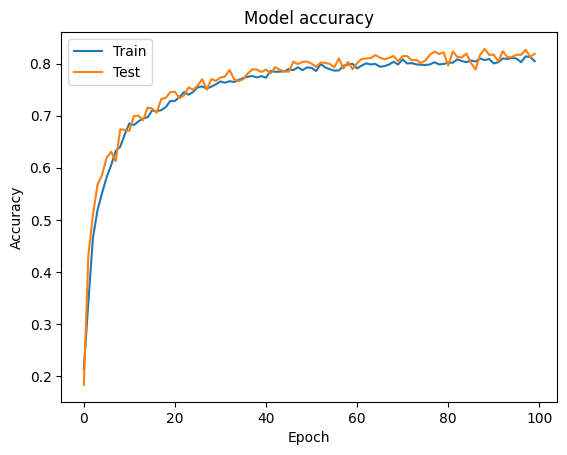

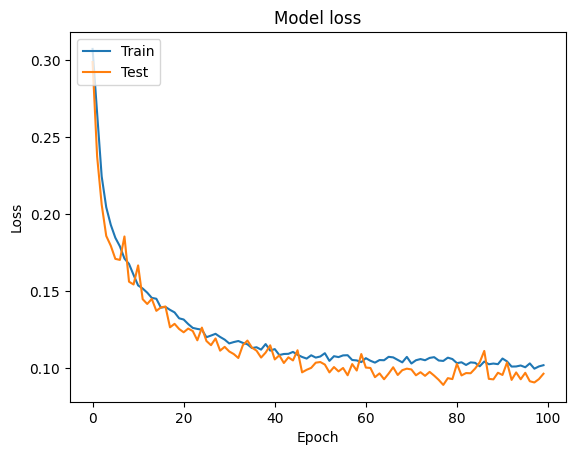

In [ ]:
# # Plot training & validation accuracy values

if train_model_1:
  print("Model 1")
  print("________________________")
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

if train_model_2:
  print("Model 2")
  print("________________________")
  plt.plot(history_2.history['accuracy'])
  plt.plot(history_2.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history_2.history['loss'])
  plt.plot(history_2.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

if train_model_3:
  print("Model 3")
  print("________________________")
  plt.plot(history_3.history['accuracy'])
  plt.plot(history_3.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history_3.history['loss'])
  plt.plot(history_3.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

if train_model_4:
  print("Model 4")
  print("________________________")
  plt.plot(history_4.history['accuracy'])
  plt.plot(history_4.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history_4.history['loss'])
  plt.plot(history_4.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

Format Results in XLSX

In [ ]:
import pandas as pd


def save_metrics_to_excel(loss, accuracy, val_loss, val_accuracy, filename='metrics.xlsx'):
    # Creating a DataFrame from the input lists
    data = {
        'Epochs': list(range(1, len(accuracy) + 1)),
        'Loss': loss,
        'Accuracy': accuracy,
        'Test Set Loss': val_loss,
        'Test Set Accuracy': val_accuracy
    }
    df = pd.DataFrame(data)

    # Creating a writer object and not saving the DataFrame immediately
    writer = pd.ExcelWriter(filename, engine='openpyxl')

    # Splitting the DataFrame into groups of 20 and writing each group to the Excel file
    epochs_per_group = 20
    start_row = 0
    for i in range(0, len(df), epochs_per_group):
        end_row = min(i + epochs_per_group, len(df))
        df_group = df.iloc[i:end_row].T
        df_group.to_excel(writer, startrow=start_row, header=False, index=True)
        start_row += epochs_per_group + 4  # 4 extra rows (2 for data and 2 as spacer)

    # Saving the Excel file
    writer.save()

#save_metrics_to_excel(history.history['loss'], history.history['accuracy'], history.history['val_loss'], history.history['val_accuracy'])

save_metrics_to_excel(history_2.history['loss'], history_2.history['accuracy'], history_2.history['val_loss'], history_2.history['val_accuracy'], "metrics_2.xlsx")

<ipython-input-52-6919f6e54501>:28: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


Find Model Accuracy With Test Dataset

In [ ]:
test_loss, test_acc = xmodel_3.evaluate(validation_batch_generator)
print(test_loss)
print(test_acc)


   10/36174 [..............................] - ETA: 7:16 - loss: 0.0899 - accuracy: 0.8156

<ipython-input-10-e29eb874733f>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.ceil(len(self.words) / float(self.batch_size))).astype(np.int)


15952/36174 [============>.................] - ETA: 3:32 - loss: 0.0926 - accuracy: 0.8165

KeyboardInterrupt: 

Manual Predictions

In [ ]:
languages = ['De', 'En', 'Es', 'Fr']
Z = xmodel.predict([word_to_one_hot("lieben")])
results = Z.tolist()
print(results)
#print(calculate_percentages(Z.tolist()))
print(languages[np.argmax(Z)])

1/1 [==============================] - 0s 34ms/step
[[0.8968440890312195, 0.07915319502353668, 0.009240814484655857, 0.014761943370103836]]
De
